In [67]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

### Read data

In [2]:
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States.nc")

In [ ]:
#resample to month ends
mhm_fluxes_mon= mhm_fluxes.resample(time='ME').mean()

In [ ]:
#select values for June
data=mhm_fluxes_mon.sel(time=mhm_fluxes_mon.time.dt.month==6)

#select a time series from a specific location
sample_ts = mhm_fluxes_mon['SM_Lall'].sel(lon=5.5, lat=51.5, method='nearest')
sample_ts1 = data['SWC_Lall'].sel(lon=slice(5.5,5.7), lat=slice(51.5,51.7)).mean(dim=['lat','lon'])

In [114]:
mhm_fluxes_mon['SM_Lall']

<xarray.DataArray 'SM_Lall' (time: 636, lat: 112, lon: 160)>
array([[[       nan,        nan,        nan, ..., 0.73535803,
         0.74755176, 0.7521888 ],
        [       nan,        nan,        nan, ..., 0.72877086,
         0.75299874, 0.74718568],
        [       nan,        nan,        nan, ..., 0.74384782,
         0.75965232, 0.74520956],
        ...,
        [0.70108821, 0.70683852, 0.71296736, ..., 0.89348329,
         0.90393742, 0.88104315],
        [0.68639037, 0.72202338, 0.72608664, ..., 0.8919666 ,
         0.88220473, 0.86855141],
        [0.69314974, 0.72818332, 0.72851072, ..., 0.88295163,
         0.86815137, 0.86884447]],

       [[       nan,        nan,        nan, ..., 0.76731783,
         0.77700243, 0.78245341],
        [       nan,        nan,        nan, ..., 0.75711108,
         0.78254382, 0.77959416],
        [       nan,        nan,        nan, ..., 0.77354859,
         0.78952953, 0.77463701],
...
        [0.61185599, 0.61623747, 0.62420582, ..., 0.736642  ,
         0.74790699, 0.71021069],
        [0.65695655, 0.63585835, 0.63874001, ..., 0.73367279,
         0.71125729, 0.68464614],
        [0.713738  , 0.64286338, 0.64432904, ..., 0.71246001,
         0.68151551, 0.67943923]],

       [[       nan,        nan,        nan, ..., 0.85412947,
         0.73496778, 0.73093561],
        [       nan,        nan,        nan, ..., 0.73077405,
         0.73334785, 0.80577462],
        [       nan,        nan,        nan, ..., 0.73159778,
         0.73716456, 0.73138287],
        ...,
        [0.63383974, 0.63832765, 0.64627606, ..., 0.76864137,
         0.78022114, 0.74277597],
        [0.6789964 , 0.65782783, 0.66078831, ..., 0.76575764,
         0.74386797, 0.71755964],
        [0.73590654, 0.66496026, 0.66653848, ..., 0.74510427,
         0.71463176, 0.71286232]]])
Coordinates:
  * lon      (lon) float64 2.016 2.047 2.078 2.109 ... 6.891 6.922 6.953 6.984
  * lat      (lat) float64 51.98 51.95 51.92 51.89 ... 48.61 48.58 48.55 48.52
  * time     (time) datetime64[ns] 1970-01-31 1970-02-28 ... 2022-12-31
Attributes:
    long_name:  average soil moisture over all layers
    units:      mm mm-1

In [65]:
ts_df = sample_ts.to_dataframe().drop(columns=['lat', 'lon'])

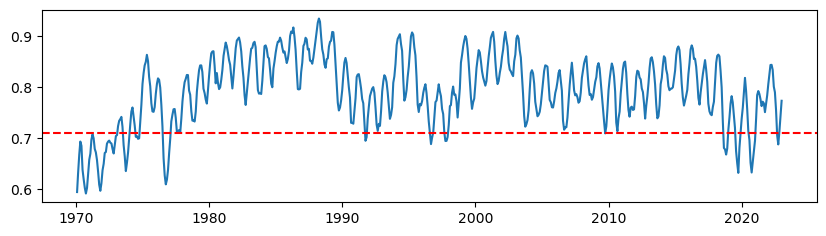

In [62]:
fig,ax=plt.subplots(figsize=(10,2.5))
plt.plot(ts_df.index, ts_df['SM_Lall'])
plt.axhline(y=0.71, color='r', linestyle='--')

#### SMI and drought characteristics

ref: https://www.nature.com/articles/s41558-018-0138-5

$SMI_{t} = F_{T}(x_{t})$


 Represents the quantile at the soil moisture fraction value x (normalized against the saturated soil water content). x t denotes the simulated monthly soil moisture fraction at a time t and is the empirical distribution function estimated using the kernel density estimator, $f_{t}(x)$

 $f_{t}(x) = \frac{1}{nh}\sum_{k=1}^{n}K(\frac{x-x_{k}}{h})$
  

 Here, $x_{1}$, …, $x_{n}$ n represents the simulated soil moisture fraction of a given calendar month during the reference period T; n denotes the number of calendar months within a given period (that is, 30 for a 30-year period); and $K$ represents a Gaussian kernel function with a bandwidth h. The bandwidth is estimated with GridSearch.
 
$K(x, x_{k}) = \frac{1}{\sqrt{2\pi h^{2}}}\exp(\frac{(x-x_{k})^{2}}{2h^{2}})$

A cell at time t is under drought when SMI t  < $\tau$. Here, $\tau$ denotes that the soil water content in this cell is less than the values occurring $\tau$ × 100% of the time. In this study, τ is set to 0.2
 

  
### Bandwidth selection
Find the optimal bandwidth h for the distribution function.
GridsearchCV

-- --
Alternatively using Silverman's rule (has limitations)


https://towardsdatascience.com/bounded-kernel-density-estimation-2082dff3f47f

Silverman's rule of thumb, optimal when the underlying density being estimated is Gaussian

$h = \sigma * (\frac{4}{3n})^{-0.2}$

In [ ]:
#GridSearchCV to find the optimal bandwidth
#extract values
soil_moisture = ts_df.values[:,0]
# Define a range of bandwidths to test
bandwidths =np.linspace(0.001, 0.9, 500)

# Perform cross-validated grid search for bandwidth h
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation
grid.fit(soil_moisture[:, None])

# Optimal bandwidth
optimal_h = grid.best_params_['bandwidth']
print(f"Optimal bandwidth: {optimal_h}")

Optimal bandwidth: 0.03883366733466934


#### Kernel Density Estimation

Text(0, 0.5, 'Probability Density')

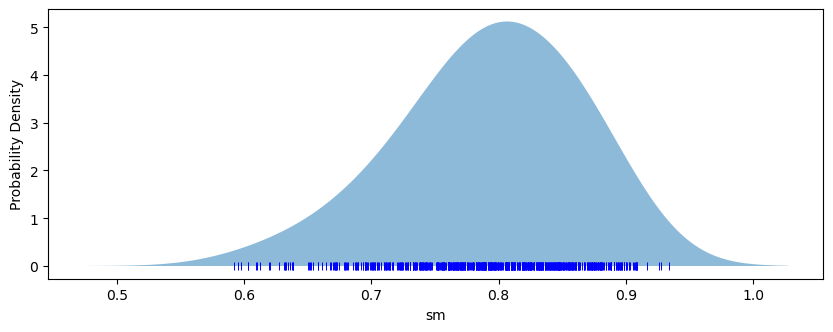

In [ ]:
# kernel density estimation
kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
kde.fit(soil_moisture[:, None]) #fit the KDE model to the data

#plot the kde
x = np.linspace(soil_moisture.min() * 0.8, soil_moisture.max() * 1.1, 1000) 
#x used for evaluating the kernel density estimation (KDE) does not have to be the same as the original data points.
#  Instead, x is typically chosen as a smooth, evenly spaced range of values that covers the domain of the data.
#  This ensures that the KDE curve is displayed smoothly over the range of interest.
# x is for the visualization of the KDE, not for determining the underlying probabilities of your data

#evaluate the KDE at the x values
#range of soil moisture values
logprob = kde.score_samples(x[:, None]) #log of the probability density function

#probability density function
prob_density = np.exp(logprob)

#plot the KDE
fig, ax = plt.subplots(figsize=(10, 3.5))

plt.fill_between(x, prob_density, alpha=0.5)
#plot vertical lines (|) representing the soil moisture values, with height equal to -0.01
plt.plot(soil_moisture, np.full_like(soil_moisture, -0.01), '|b', markeredgewidth=0.7)
plt.xlabel('sm')
plt.ylabel('Probability Density')

### Cumulative distribution function

Integrate the probability distribution function to obtain the CDF

In [112]:
# Compute the CDF by integrating the PDF
cdf = np.cumsum(prob_density) * (x[1] - x[0])

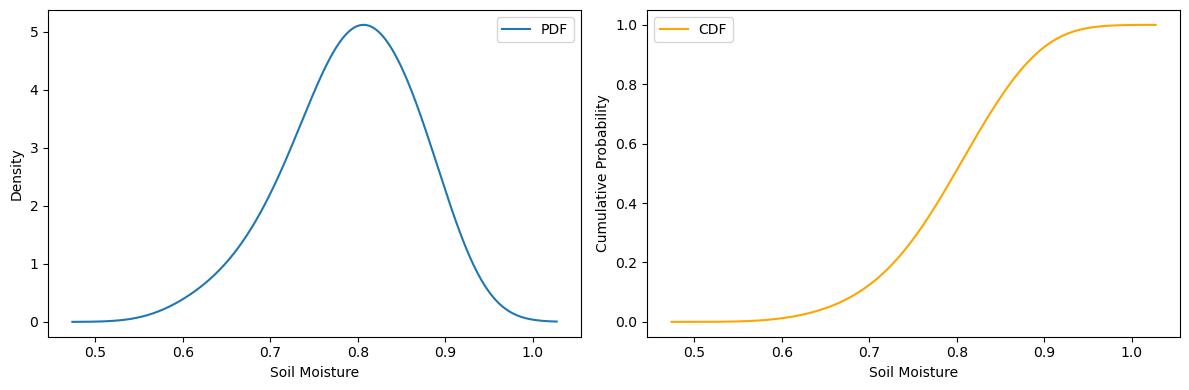

In [113]:
# Plot the PDF and CDF
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, prob_density, label='PDF')
plt.xlabel('Soil Moisture')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, cdf, label='CDF', color='orange')
plt.xlabel('Soil Moisture')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.tight_layout()
plt.show()

In [141]:
import numpy as np
from sklearn.neighbors import KernelDensity
import xarray as xr

# Function to compute CDF for a single grid cell
def compute_cdf_for_cell(soil_moisture_timeseries, optimal_h):
    # Ensure the timeseries is a 1D array
    soil_moisture_timeseries = soil_moisture_timeseries.flatten()

    # Remove NaN values from the timeseries
    soil_moisture_timeseries = soil_moisture_timeseries[~np.isnan(soil_moisture_timeseries)]

    # If the timeseries is empty after removing NaNs, return NaN array for that cell
    if len(soil_moisture_timeseries) == 0:
        return np.full(1000, np.nan)

    # Fit Kernel Density Estimation (KDE) to the timeseries data
    kde = KernelDensity(bandwidth=optimal_h, kernel='gaussian')
    kde.fit(soil_moisture_timeseries[:, None])  # Fit KDE to the soil moisture timeseries

    # Generate range of x values (for CDF computation)
    x = np.linspace(soil_moisture_timeseries.min() * 0.8, soil_moisture_timeseries.max() * 1.1, 1000)

    # Evaluate the KDE at the x values (log-probabilities)
    logprob = kde.score_samples(x[:, None])

    # Convert log-probabilities to probability density function (PDF)
    prob_density = np.exp(logprob)

    # Compute CDF by integrating the PDF using the trapezoidal rule
    cdf = np.cumsum(prob_density) * (x[1] - x[0])

    # Return the full CDF array for the grid cell
    return cdf

# Main function to compute CDF for all grid cells
def compute_cdf(dataset, optimal_h, month):
    # Filter dataset for the given month
    data_month = dataset.sel(time=dataset.time.dt.month == month)

    # Impute missing values using forward fill or interpolation (if necessary)
    #data_month = data_month.fillna(method='ffill', dim='time')

    # Extract soil moisture timeseries for each grid cell
    soil_moisture_timeseries = data_month.values

    # Apply the compute_cdf_for_cell function across each grid cell
    cdf_values = xr.apply_ufunc(
        compute_cdf_for_cell,  # Function to apply
        soil_moisture_timeseries,  # Soil moisture time series for each grid cell
        optimal_h,  # The bandwidth for KDE
        input_core_dims=[['time'], []],  # Apply across the 'time' dimension (each time series per grid cell)
        vectorize=True,  # Vectorize to process all grid cells
        output_dtypes=[float],  # Output will be an array of CDF values for each grid cell
        output_sizes={'x': 1000}  # Specify the output size for the CDF (1000 points)
    )

    return cdf_values



In [ ]:
# Example usage: Compute the CDF for the 6th month (June) with the given optimal bandwidth (e.g., optimal_h=0.2)
cdf_values = compute_cdf(mhm_fluxes_mon['SM_Lall'], optimal_h=0.2, month=6)



In [144]:
cdf_values.shape

(1000,)